In [1]:
import cv2
import numpy as np
import pandas as pd 
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

In [15]:
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]


In [3]:
wiki_process =  pd.read_csv("wiki_process.csv")

In [4]:
wiki_process.head()

,gender,img_path,age
0,1.0,17/10000217_1981-05-05_2009.jpg,27
1,1.0,12/100012_1948-07-03_2008.jpg,59
2,0.0,16/10002116_1971-05-31_2012.jpg,40
3,0.0,02/10002702_1960-11-09_2012.jpg,51
4,1.0,41/10003541_1937-09-27_1971.jpg,33


In [48]:
start = time.time()

try:  
    with tf.device('/device:GPU:5'):
        image_list = []
        for path in wiki_process["img_path"]:
#             if count == 500:
#                 break
#             else:
            img = cv2.imread("wiki_crop/" + path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(200,200))
            image_list.append(img)
#                 count += 1
except RuntimeError as e:
  print(e)
end = time.time()
print("time taken for execution :- {}".format(end-start))

time taken for execution :- 38.26952052116394


In [6]:
# wiki_process = wiki_process.head(500)
wiki_process["image"] = image_list
wiki_process.head()

,gender,img_path,age,image
0,1.0,17/10000217_1981-05-05_2009.jpg,27,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,1.0,12/100012_1948-07-03_2008.jpg,59,"[[95, 91, 93, 96, 98, 99, 97, 93, 93, 95, 96, ..."
2,0.0,16/10002116_1971-05-31_2012.jpg,40,"[[37, 37, 37, 37, 37, 37, 37, 37, 37, 36, 36, ..."
3,0.0,02/10002702_1960-11-09_2012.jpg,51,"[[121, 121, 121, 122, 122, 122, 123, 123, 123,..."
4,1.0,41/10003541_1937-09-27_1971.jpg,33,"[[190, 204, 202, 197, 202, 202, 200, 201, 204,..."


In [7]:
wiki_process.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39455 entries, 0 to 39454
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    39455 non-null  float64
 1   img_path  39455 non-null  object 
 2   age       39455 non-null  int64  
 3   image     39455 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.2+ MB


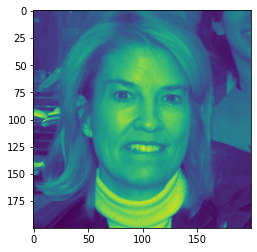

In [8]:
plt.imshow(wiki_process["image"][39454])

In [9]:
#normalizing the pixel values
try:  
    with tf.device('/device:GPU:7'):
        x_data = np.array(image_list)/255
        y_data = wiki_process["gender"].to_numpy()
except RuntimeError as e:
  print(e)

In [10]:
x_data.shape

(39455, 200, 200)

In [11]:
y_data.shape

(39455,)

In [12]:
# image_x will contain the original grayscale images 
x_data = x_data.reshape((x_data.shape[0],200,200,1))

print("x_data shape: {}".format(x_data.shape))
print("y_data shape: {}".format(y_data.shape))

x_data shape: (39455, 200, 200, 1)
y_data shape: (39455,)


In [13]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}\n".format(train_y.shape))

print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

train_x shape: (26434, 200, 200, 1)
train_y shape: (26434,)

test_x shape: (13021, 200, 200, 1)
test_y shape: (13021,)


In [14]:
# num_subjects = np.unique(y_data).shape[0]
# print("Number of subjects: {}".format(np.unique(y_data).shape[0]))

# Tensorflow

In [33]:
try:  
    with tf.device('/device:GPU:7'):
        # specify the input size of the images
        images = Input((train_x.shape[1], train_x.shape[2], 1,))
        # a convolution layer of 32 filters of size 9x9 to extract features (valid padding)
        x = Conv2D(2,kernel_size=(15,15),padding="valid")(images)
        # a maxpooling layer to down-sample features with pool size (2, 2)
        x = MaxPool2D(pool_size=(2,2))(x)
        #  # another convolution layer of 64 filters of size 11x11 to extract features (valid padding)
        x = Conv2D(64,kernel_size=(15,15),padding="valid")(x)
        # # # a maxpooling layer to down-sample features with pool size (2, 2)
        x = MaxPool2D(pool_size=(2,2))(x)
        # flatten extracted features to form feature vector
        x = Flatten()(x)
        # a drop out layer for regularization (25% probability)
        x = Dropout(rate=0.3,seed=0.25)(x)
        # first fully-connected layer to map the features to vectors of size 256
        x = Dense(128,activation="relu")(x)
        # anoter drop out layer for regularization (25% probability)
        x = Dropout(rate=0.3,seed=0.25)(x)
        # a second fully-connected layer to map the features to a logit vector with one logit per subject
        x = Dense(1)(x)
        # use softmax activation to convert the logits to class probabilities for each subject
        predictions = Activation("sigmoid")(x)

        # create the model using the layers we defined previously
        sample_cnn = Model(inputs=images, outputs=predictions)

        # compile the model so that it uses Adam for optimization during training with cross-entropy loss
        sample_cnn.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["acc"])

        # print out a summary of the model achitecture
        print(sample_cnn.summary())

except RuntimeError as e:
  print(e)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 186, 186, 2)       452       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 93, 93, 2)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 79, 79, 64)        28864     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 97344)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 97344)             0   

In [40]:
start = time.time()
# class_weights = compute_class_weight("balanced", np.unique(train_y), train_y)
# class_weights = dict(enumerate(class_weights))
try:  
    with tf.device('/device:GPU:7'):
        # train model
        history = sample_cnn.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=16, verbose=1)
except RuntimeError as e:
  print(e)
end = time.time()
print("Time spent for training - {}".format(end-start))

Epoch 1/16
827/827 [==============================] - 23s 28ms/step - loss: 0.1331 - acc: 0.9494 - val_loss: 0.4285 - val_acc: 0.8579
Epoch 2/16
827/827 [==============================] - 23s 28ms/step - loss: 0.1144 - acc: 0.9562 - val_loss: 0.4489 - val_acc: 0.8562
Epoch 3/16
827/827 [==============================] - 23s 28ms/step - loss: 0.1020 - acc: 0.9619 - val_loss: 0.5068 - val_acc: 0.8580
Epoch 4/16
827/827 [==============================] - 23s 28ms/step - loss: 0.0853 - acc: 0.9701 - val_loss: 0.4899 - val_acc: 0.8561
Epoch 5/16
827/827 [==============================] - 23s 28ms/step - loss: 0.0706 - acc: 0.9744 - val_loss: 0.5247 - val_acc: 0.8555
Epoch 6/16
827/827 [==============================] - 23s 28ms/step - loss: 0.0681 - acc: 0.9766 - val_loss: 0.5652 - val_acc: 0.8605
Epoch 7/16
827/827 [==============================] - 23s 28ms/step - loss: 0.0661 - acc: 0.9768 - val_loss: 0.5428 - val_acc: 0.8583
Epoch 8/16
827/827 [==============================] - 24s 29ms

In [47]:
# try:  
#     with tf.device('/device:GPU:7'):
#         # evaluate model, get train/test accuracy
#         train_pred = np.array(sample_cnn.predict(train_x))
#         test_pred = np.array(sample_cnn.predict(test_x))
#         print("\nTraining accuracy using sample CNN model: {}".format(accuracy_score(train_y, train_pred)))
#         print("Testing accuracy using sample CNN model: {}\n".format(accuracy_score(test_y, test_pred)))
# except RuntimeError as e:
#   print(e)

In [41]:
try:  
    with tf.device('/device:GPU:7'):
        test_pred = sample_cnn.predict(test_x)
        for i in test_pred:
            if i[0] >= 0.5:
                i[0] = 1
            else:
                i[0] = 0
        print(test_pred)
except RuntimeError as e:
  print(e)

[[1.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]


In [42]:
test_pred[test_pred<0.5]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [43]:
print(classification_report(test_y,test_pred))
print(confusion_matrix(test_y,test_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.62      0.69      3204
         1.0       0.88      0.94      0.91      9817

    accuracy                           0.86     13021
   macro avg       0.83      0.78      0.80     13021
weighted avg       0.86      0.86      0.86     13021

[[2000 1204]
 [ 578 9239]]


In [52]:
test_y[0]

1.0

In [30]:
# for i in test_pred:
#     if i[0] >= 0.5:
#         i[0] = 1
#     else:
#         i[0] = 0
# test_pred

In [44]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

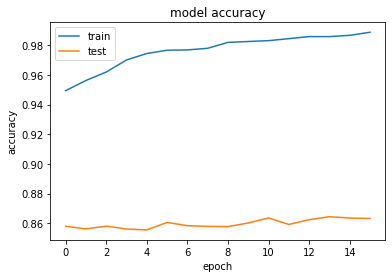

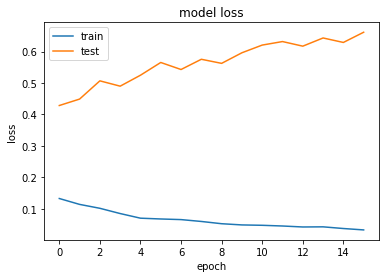

In [47]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
# sample_cnn.save("Project/cnn1_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Project/cnn1_model/assets
